In [3]:

from monai.utils import first, set_determinism
from monai.transforms import (EnsureChannelFirstd, Compose, CropForegroundd, LoadImaged, Orientationd, RandCropByPosNegLabeld, ScaleIntensityRanged, Spacingd)
from monai.networks.nets import DynUNet
from monai.networks.layers import Norm
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset
from monai.apps import download_and_extract
from monai.transforms import CenterSpatialCropd
from monai.transforms import Resized
import torch
import matplotlib.pyplot as plt
import os
import glob
import torch.nn as nn
import json
from datetime import datetime
from data_preparation2 import DataHandling 
from UNet_model import create_unet
import numpy as np
import nibabel as nib
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, Spacingd,
    SpatialPadd, ScaleIntensityd, CenterSpatialCropd
)

import math


/homes/zshahpouri/DLP/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
data_dir = '/homes/zshahpouri/DLP/ASC-PET-001'
directory = '/homes/zshahpouri/DLP/Practic/LOGTEST'
output_dir = '/homes/zshahpouri/DLP/Practic/OUT'

In [5]:
import math
from utils import split_data


train_images = sorted(glob.glob(os.path.join(data_dir, "NAC", "*.nii.gz")))
target_images = sorted(glob.glob(os.path.join(data_dir, "ADCM", "*.nii.gz")))
data_dicts = [{"image": img, "target": tar} for img, tar in zip(train_images, target_images)]


train_files, val_files, test_files = split_data (data_dicts)

# Print sizes for verification
print(f"Train set size: {len(train_files)}")
print(f"Validation set size: {len(val_files)}")
print(f"Test set size: {len(test_files)}")


Train set size: 131
Validation set size: 33
Test set size: 20


In [6]:
# roi_size = [168, 168, 32]

train_transforms = Compose(
    [   LoadImaged(keys=["image", "target"]),
        EnsureChannelFirstd(keys=["image", "target"]),
        Spacingd(keys=["image", "target"], pixdim=(4.07, 4.07, 3.00), mode= 'trilinear'),
        
        SpatialPadd(keys=["image", "target"], spatial_size=(168, 168, 320), mode='constant'),  # Pad to ensure minimum size
        
        RandCropByPosNegLabeld(
            keys=["image", "target"],
            label_key="target",
            spatial_size=(168, 168, 32),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),        ])

val_transforms = Compose(
    [   LoadImaged(keys=["image", "target"]),
        EnsureChannelFirstd(keys=["image", "target"]),
        Spacingd(keys=["image", "target"], pixdim=(4.07, 4.07, 3.00), mode= 'trilinear'),
        SpatialPadd(keys=["image", "target"], spatial_size=(168, 168, 320), mode='constant'),  # Ensure minimum size
        CenterSpatialCropd(keys=["image", "target"], roi_size=(168, 168, 320)),  # Ensure uniform size
    ])

# test_transforms = Compose(
#     [   LoadImaged(keys=["image", "target"]),
#         EnsureChannelFirstd(keys=["image", "target"]),
#         Spacingd(keys=["image", "target"], pixdim=(4.07, 4.07, 3.00), mode= 'trilinear'),
#         SpatialPadd(keys=["image", "target"], spatial_size=(168, 168, 320), mode='constant'),  # Ensure minimum size
#         CenterSpatialCropd(keys=["image", "target"], roi_size=(168, 168, 320)),  # Ensure uniform size
#     ])


train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0, num_workers=4)
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=4)

val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=2, shuffle=False, num_workers=4)

# test_ds = CacheDataset(data=test_files, transform=test_transforms, cache_rate=1.0, num_workers=8)
# test_loader = DataLoader(test_ds, batch_size=1, shuffle=False, num_workers=8)


Loading dataset:   0%|          | 0/131 [00:00<?, ?it/s]

Loading dataset: 100%|██████████| 33/33 [00:19<00:00,  1.66it/s]


image shape: torch.Size([168, 168, 320]), target shape: torch.Size([168, 168, 320])


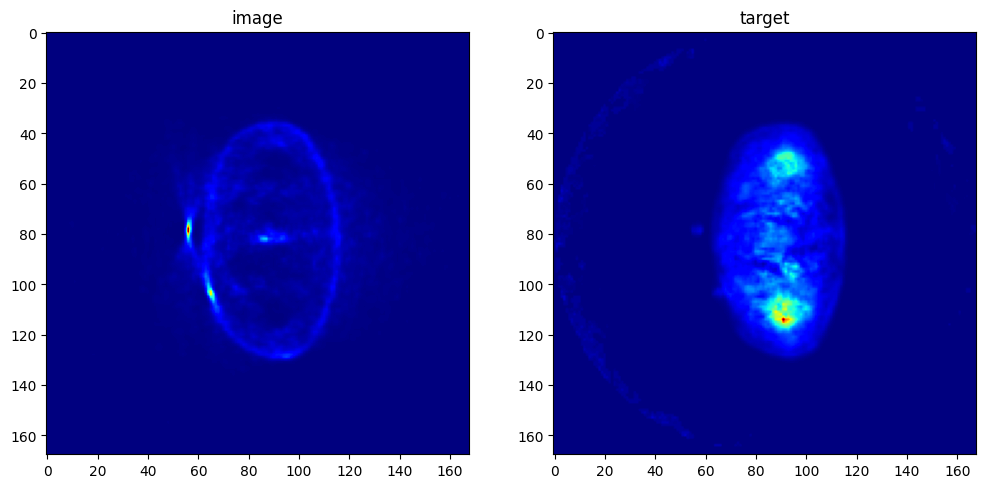

In [7]:
check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, target = (check_data["image"][0][0], check_data["target"][0][0])
print(f"image shape: {image.shape}, target shape: {target.shape}")
# plot the slice [:, :, n]
n = 100

plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, n], cmap="jet")
plt.subplot(1, 2, 2)
plt.title("target")
plt.imshow(target[:, :, n],cmap='jet' )
plt.show()

In [8]:
def find_last_saved_model(log_filepath):
    last_saved_model = None
    best_metric = None
    epoch = None
    with open(log_filepath, 'r') as file:
        for line in file:
            if "Saved" in line and ".pth" in line:
                parts = line.split(',')
                last_saved_model = parts[0].split()[1]  # Extract model filename
                best_metric = float(parts[1].split(': ')[1])  # Extract best metric
                epoch = int(parts[2].split(': ')[1])  # Extract epoch number
    return last_saved_model, best_metric, epoch


# log_filename = 'log_2_26_8_17.txt'
log_filename = 'log_3_4_12_4.txt'
log_filename = 'log_3_4_12_4.txt'

log_filepath = directory + '/'+ log_filename
bestmodel_filename, best_metric, best_epoch = find_last_saved_model(log_filepath)
print(f"Model Filename: {bestmodel_filename}, Best Metric: {best_metric}, Epoch: {best_epoch}")


Model Filename: model_3_5_8_17.pth, Best Metric: 0.0557, Epoch: 120


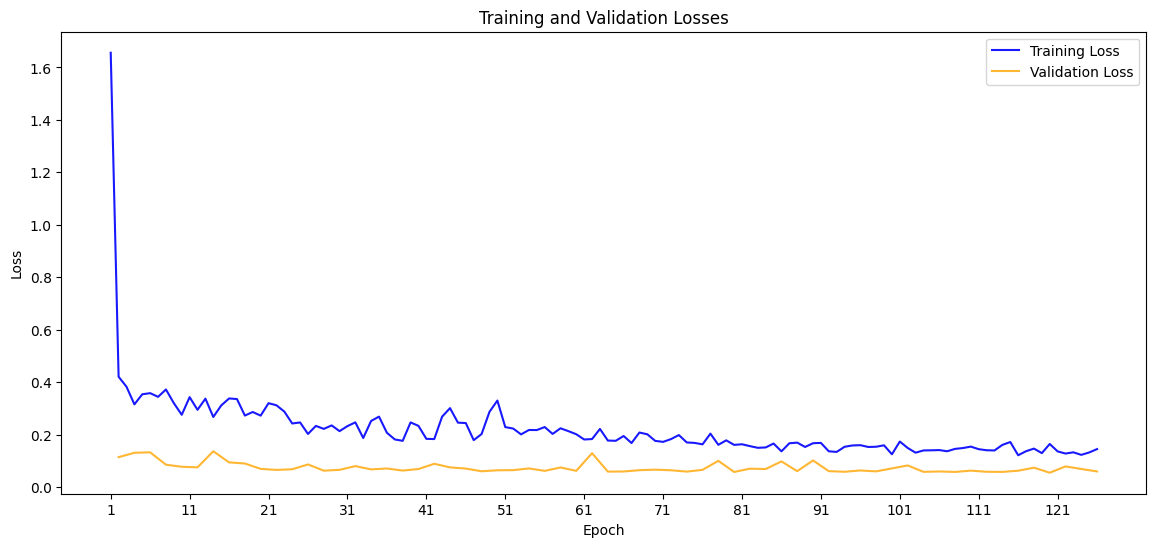

In [9]:

# Function to parse the loss values from the log file
def parse_loss_values(log_filepath):
    train_losses = []
    val_losses = []
    with open(log_filepath, 'r') as file:
        for line in file:
            if 'average loss:' in line:
                loss_value = float(line.split(': ')[-1])
                train_losses.append(loss_value)
            if 'Validation loss:' in line:
                val_loss_value = float(line.split(': ')[-1])
                val_losses.append(val_loss_value)
    return train_losses, val_losses

# Replace this with the path to your actual log file

train_losses, val_losses = parse_loss_values(log_filepath)

max_epochs = len(train_losses)
val_interval = 2  # Update this if your validation interval is different

# Plotting
plt.figure(figsize=(14, 6))
plt.plot(range(1, max_epochs + 1), train_losses, label='Training Loss', color='blue', alpha=0.9)
plt.plot(range(2, max_epochs + 1, val_interval), val_losses, label='Validation Loss', color='orange', alpha=0.8)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.xticks(np.arange(1, max_epochs + 1, 10))  # Adjust the x-axis ticks if needed
plt.show()


In [10]:
import os
import torch
from monai.networks.nets import DynUNet

def get_kernels_strides(patch_size, spacing):
    """
    Adjusted function to use the correct variable names.
    """
    sizes = patch_size  
    spacings = spacing  
    strides, kernels = [], []
    while True:
        spacing_ratio = [sp / min(spacings) for sp in spacings]
        stride = [2 if ratio <= 2 and size >= 8 else 1 for (ratio, size) in zip(spacing_ratio, sizes)]
        kernel = [3 if ratio <= 2 else 1 for ratio in spacing_ratio]
        if all(s == 1 for s in stride):
            break
        for idx, (i, j) in enumerate(zip(sizes, stride)):
            if i % j != 0:
                raise ValueError(
                    f"Patch size is not supported, please try to modify the size {patch_size[idx]} in the spatial dimension {idx}."
                )
        sizes = [i / j for i, j in zip(sizes, stride)]
        spacings = [i * j for i, j in zip(spacings, stride)]
        kernels.append(kernel)
        strides.append(stride)

    strides.insert(0, len(spacings) * [1])
    kernels.append(len(spacings) * [3])
    return kernels, strides


def get_network(patch_size, spacing):
    """
    Initializes the DynUNet with dynamically determined kernels and strides.
    """
    kernels, strides = get_kernels_strides(patch_size, spacing)
    print(kernels)
    print(strides)
    print(len(strides))
    net = DynUNet(
        spatial_dims=3,
        in_channels=1,
        out_channels=1,
        kernel_size=kernels,
        strides=strides,
        upsample_kernel_size=strides[1:],
        norm_name="instance",
        deep_supervision=True,
        deep_supr_num=2,
    )
    return net

# Example usage
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
patch_size = [168, 168, 16]
spacing = [4.07, 4.07, 3.00]
model = get_network(patch_size, spacing)
model = model.to(device)

model

[[3, 3, 3], [3, 3, 3], [3, 3, 3], [3, 3, 3]]
[[1, 1, 1], [2, 2, 2], [2, 2, 2], [2, 2, 1]]
4


DynUNet(
  (input_block): UnetBasicBlock(
    (conv1): Convolution(
      (conv): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
    )
    (conv2): Convolution(
      (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
    )
    (lrelu): LeakyReLU(negative_slope=0.01, inplace=True)
    (norm1): InstanceNorm3d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (norm2): InstanceNorm3d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  )
  (downsamples): ModuleList(
    (0): UnetBasicBlock(
      (conv1): Convolution(
        (conv): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
      )
      (conv2): Convolution(
        (conv): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      )
      (lrelu): LeakyReLU(negative_slope=0.01, inplace=True)
      (norm1): InstanceNorm3d(64, eps=1e-05

In [11]:
bestmodel_filename = 'model_3_13_16_34.pth'
best_epoch = 116
best_metric = 0.016655


In [12]:
import torch

# Assuming root_dir is the directory where your model files are stored
model_path = os.path.join(directory, bestmodel_filename)
if os.path.exists(model_path):
    print(f"Model file {bestmodel_filename} is loading.")
    model.load_state_dict(torch.load(model_path))
    model.eval()
else:
    print(f"Model file {bestmodel_filename} not found.")

Model file model_3_13_16_34.pth is loading.


In [13]:
# Extract file names
test_name = [(os.path.splitext(os.path.basename(file_info['image']))[0], os.path.splitext(os.path.basename(file_info['target']))[0]) for file_info in test_files]

from monai.transforms import Invertd, SaveImaged, Compose, LoadImaged, EnsureChannelFirstd
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch


test_org_transforms = Compose(
    [   LoadImaged(keys=["image", "target"]),
        EnsureChannelFirstd(keys=["image", "target"]),
        Spacingd(keys=["image", "target"], pixdim=(4.07, 4.07, 3.00), mode= 'trilinear'),
        SpatialPadd(keys=["image", "target"], spatial_size=(168, 168, 320), mode='constant'),  # Ensure minimum size
        CenterSpatialCropd(keys=["image", "target"], roi_size=(168, 168, 320)),  # Ensure uniform size
    ])




test_org_ds = Dataset(data=test_files, transform=test_org_transforms)
test_org_loader = DataLoader(test_org_ds, batch_size=1, num_workers=4)




In [14]:
test_name

[('007026_C5_RJ_.nii', '007026_C5_RJ_adcm.nii'),
 ('007035_C5_RJ_.nii', '007035_C5_RJ_adcm.nii'),
 ('007037_C5_RJ_.nii', '007037_C5_RJ_adcm.nii'),
 ('007038_C5_RJ_.nii', '007038_C5_RJ_adcm.nii'),
 ('007042_C5_RJ_.nii', '007042_C5_RJ_adcm.nii'),
 ('007043_C5_RJ_.nii', '007043_C5_RJ_adcm.nii'),
 ('007046_C5_RJ_.nii', '007046_C5_RJ_adcm.nii'),
 ('007051_C5_RJ_.nii', '007051_C5_RJ_adcm.nii'),
 ('007057_C5_RJ_.nii', '007057_C5_RJ_adcm.nii'),
 ('007058_C5_RJ_.nii', '007058_C5_RJ_adcm.nii'),
 ('007066_C5_RJ_.nii', '007066_C5_RJ_adcm.nii'),
 ('007067_C5_RJ_.nii', '007067_C5_RJ_adcm.nii'),
 ('001595_C1_RZ_.nii', '001595_C1_RZ_adcm.nii'),
 ('001216_C1_RZ_.nii', '001216_C1_RZ_adcm.nii'),
 ('002301_C2_IM_.nii', '002301_C2_IM_adcm.nii'),
 ('002401_C2_IM_.nii', '002401_C2_IM_adcm.nii'),
 ('003232_C3_KH_.nii', '003232_C3_KH_adcm.nii'),
 ('003221_C3_KH_.nii', '003221_C3_KH_adcm.nii'),
 ('004136_C4_SH_.nii', '004136_C4_SH_adcm.nii'),
 ('004123_C4_SH_.nii', '004123_C4_SH_adcm.nii')]

100%|██████████| 7/7 [00:37<00:00,  5.29s/it]


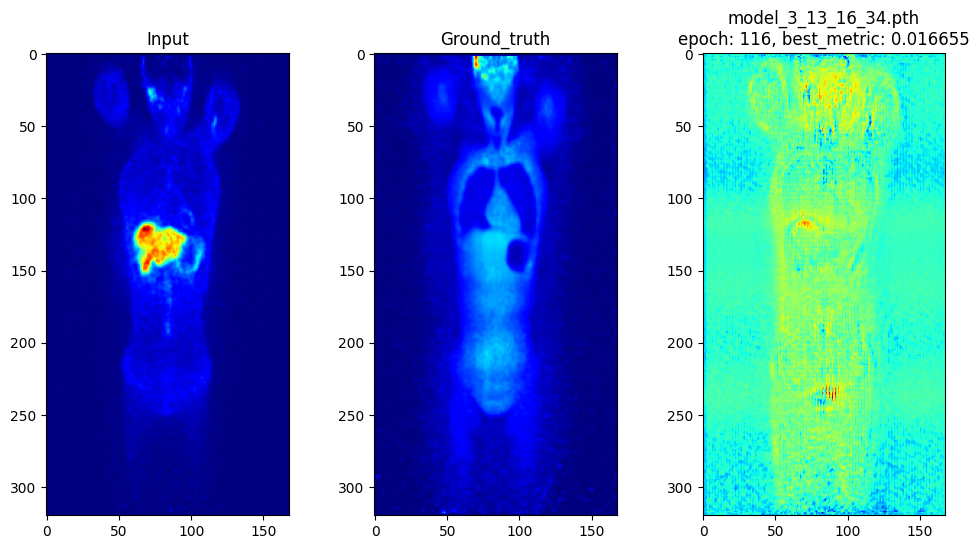

100%|██████████| 7/7 [00:36<00:00,  5.28s/it]


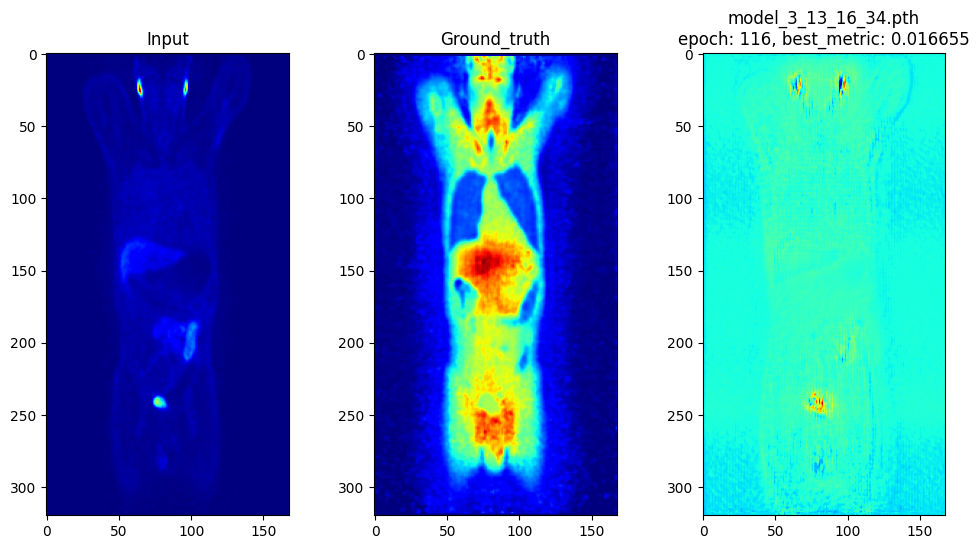

In [15]:


# Define a function for visualization
def visualize_results(val_data, model, n, title):

    val_outputs = sliding_window_inference(val_data["image"].to(device), roi_size,
                          sw_batch_size, model, progress=True, overlap=0.90) # using ov= 0.9 best image ever I have.


    plt.figure("check", (12, 6))

    plt.subplot(1, 3, 1)
    plt.title(f"Input")
    input_slice = np.rot90(val_data["image"][0, 0, :, n, :])
    plt.imshow(input_slice, cmap="jet")

    plt.subplot(1, 3, 2)
    plt.title(f"Ground_truth")
    target_slice = np.rot90(val_data["target"][0, 0, :, n, :])
    plt.imshow(target_slice, cmap="jet")

    plt.subplot(1, 3, 3)
    plt.title(title)
    output_slice = np.rot90(val_outputs.detach().cpu()[0, 0, :, n, :])
    plt.imshow(output_slice, cmap="jet")
    
    plt.show()


roi_size = (168, 168, 32)
sw_batch_size = 16
with torch.no_grad():
    for i, val_data in enumerate(test_org_loader):

        n = 80
        visualize_results(val_data, model, n, f"{bestmodel_filename}\nepoch: { best_epoch}, best_metric: {best_metric}")
        if i == 1:
            break




----
# Export dl_adcm images

In [16]:
# Extract file names

post_transforms = Compose(
    [
        Invertd(
            keys="pred",
            transform=test_org_transforms,
            orig_keys="image",
            meta_keys="pred_meta_dict",
            orig_meta_keys="image_meta_dict",
            meta_key_postfix="meta_dict",
            nearest_interp=False,
            to_tensor=True,
        ),
        SaveImaged(keys="pred", meta_keys="pred_meta_dict", output_dir=output_dir, output_postfix="dl_adcm3", resample=False),
    ]
)
model.eval()

with torch.no_grad():
    for test_data in test_org_loader:
        test_inputs = test_data["image"].to(device)
        test_data["pred"] = sliding_window_inference(test_inputs, roi_size, sw_batch_size, model, overlap=0.90)
        test_data = [post_transforms(i) for i in decollate_batch(test_data)]


2024-03-13 16:43:09,653 INFO image_writer.py:197 - writing: /homes/zshahpouri/DLP/Practic/OUT/007026_C5_RJ_/007026_C5_RJ__dl_adcm3.nii.gz
2024-03-13 16:43:46,850 INFO image_writer.py:197 - writing: /homes/zshahpouri/DLP/Practic/OUT/007035_C5_RJ_/007035_C5_RJ__dl_adcm3.nii.gz


KeyboardInterrupt: 